
最优卖出Put期权候选：
   Symbol      K    T  Premium Diff     Delta     Theta
21   AAPL  211.6  1.0      5.843663 -0.272254 -5.788778
20   AAPL  211.6  0.9      5.238300 -0.272745 -6.331969
19   AAPL  211.6  0.8      4.574209 -0.272634 -6.967237
18   AAPL  211.6  0.7      3.840860 -0.271665 -7.722737
17   AAPL  211.6  0.6      3.024288 -0.269434 -8.640183


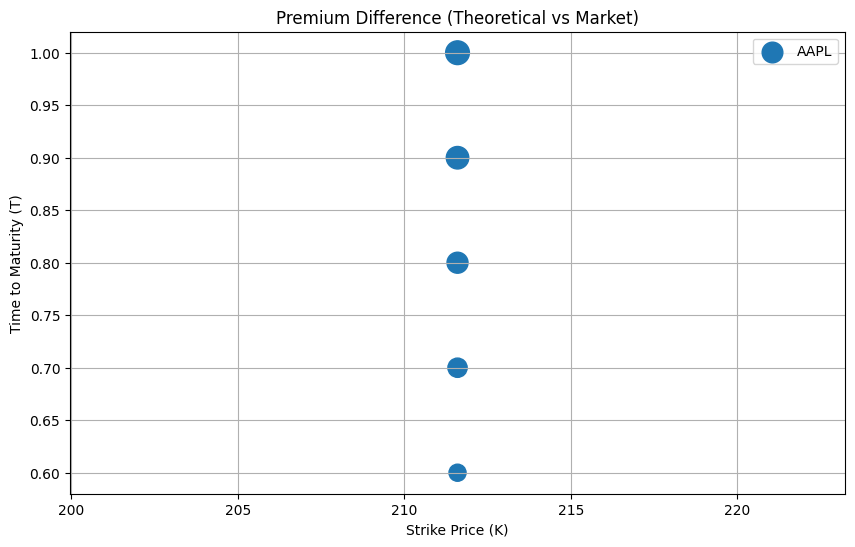

In [4]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

class PutOptionStrategy:
    def __init__(self, S, r=0.05, q=0.0):
        self.S = S          # 当前股价
        self.r = r          # 无风险利率
        self.q = q          # 股息率

    def black_scholes_put(self, K, T, sigma):
        """计算欧式看跌期权的理论价格和希腊值"""
        d1 = (np.log(self.S / K) + (self.r - self.q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-self.r * T) * norm.cdf(-d2) - self.S * np.exp(-self.q * T) * norm.cdf(-d1)
        
        # 计算希腊值
        delta = -norm.cdf(-d1) * np.exp(-self.q * T)
        vega = self.S * np.exp(-self.q * T) * norm.pdf(d1) * np.sqrt(T)
        theta = (-self.S * np.exp(-self.q * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) 
                 + self.r * K * np.exp(-self.r * T) * norm.cdf(-d2))
        
        return put_price, delta, vega, theta

    def find_optimal_put(self, sigma, market_price, K_range, T_range):
        """寻找最优行权价和到期时间"""
        results = []
        for K in K_range:
            for T in T_range:
                theoretical_price, delta, vega, theta = self.black_scholes_put(K, T, sigma)
                premium_diff = theoretical_price - market_price  # 理论价与市场价差异
                if premium_diff > 0:  # 仅考虑理论价高于市场价的期权（被高估）
                    results.append({
                        "K": K,
                        "T": T,
                        "Theoretical Price": theoretical_price,
                        "Market Price": market_price,
                        "Premium Diff": premium_diff,
                        "Delta": delta,
                        "Vega": vega,
                        "Theta": theta
                    })
        
        df = pd.DataFrame(results)
        if df.empty:
            return None
        # 按溢价差异和Theta衰减排序（优先高溢价+低Theta）
        df["Score"] = df["Premium Diff"] * 0.7 + (-df["Theta"]) * 0.3
        df = df.sort_values("Score", ascending=False)
        return df.head(5)  # 返回前5名候选

# 示例：多标的物分析
if __name__ == "__main__":
    # 定义多个标的物（假设不同股票的S和σ不同）
    stocks = [
        {"symbol": "AAPL", "S": 227, "sigma": 0.25}
    ]
    
    market_price = 5  # 市场期权价格
    K_range = np.arange(0.8 * 227, 0.95 * 227, 5)  # 行权价范围（AAPL示例）
    T_range = np.linspace(0.1, 1.0, 10)  # 到期时间（年）
    
    all_results = []
    for stock in stocks:
        model = PutOptionStrategy(S=stock["S"], r=0.05, q=0.0)
        df = model.find_optimal_put(
            sigma=stock["sigma"],
            market_price=market_price,
            K_range=K_range,
            T_range=T_range
        )
        if df is not None:
            df["Symbol"] = stock["symbol"]
            all_results.append(df)
    
    if all_results:
        final_df = pd.concat(all_results)
        print("\n最优卖出Put期权候选：")
        print(final_df[["Symbol", "K", "T", "Premium Diff", "Delta", "Theta"]])
        
        # 可视化溢价差异
        plt.figure(figsize=(10, 6))
        for symbol in final_df["Symbol"].unique():
            subset = final_df[final_df["Symbol"] == symbol]
            plt.scatter(subset["K"], subset["T"], s=subset["Premium Diff"]*50, label=symbol)
        plt.xlabel("Strike Price (K)")
        plt.ylabel("Time to Maturity (T)")
        plt.title("Premium Difference (Theoretical vs Market)")
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("未找到符合条件的期权")